In [9]:
%matplotlib notebook
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from scipy import signal
from ipyparallel import Client
from ipyparallel import depend, require, dependent
from roipoly import roipoly
from scipy.ndimage import gaussian_filter

import os
from os.path import join, getsize

#Shape of the data
height = 256
width = 256

#28.815 and 86.5576
#90.14531424656546
TRUE_FRAMERATE = 28.815

In [74]:
# AUTOMATIC EXPERIMENT SELECTOR
directory = "/media/gu4n1n3/Data2/2_mice/20180221/"
experiment = "Experiment_5/"


all_files = None
for root, dirs, files in os.walk(directory+experiment):
    if not "Behaviour" in root and "Maps" not in root:
        all_files = files

print(all_files)
left_mouse = None
right_mouse = None
prev_video_file = None
prev_timestamps_file = None
left_mouse_timestamps_file = None
right_mouse_timestamps_file = None
stim_frames_file = None
for i, file in enumerate(all_files):
    if ".raw" in file and "combined" not in file and 'mask' not in file and 'special' not in file and 'mean' not in file \
       and 'processed' not in file and "testing" not in file and "lmao" not in file:
        if "timestamps" in file:
            
            if prev_timestamps_file == None:
                prev_timestamps_file = file
            else:
                if file.index("L") < prev_timestamps_file.index("L"):
                    left_mouse_timestamps_file = directory+experiment+file
                    right_mouse_timestamps_file = directory+experiment+prev_timestamps_file
                else:
                    left_mouse_timestamps_file = directory+experiment+prev_timestamps_file
                    right_mouse_timestamps_file = directory+experiment+file
        else:
            if prev_video_file == None:
                prev_video_file = file
            else:
                if file.index("L") < prev_video_file.index("L"):
                    left_mouse = directory+experiment+file
                    right_mouse = directory+experiment+prev_video_file
                else:
                    left_mouse = directory+experiment+prev_video_file
                    right_mouse = directory+experiment+file
    elif ".txt" in file:
        stim_frames_file = directory+experiment+file


#right_mouse = left_mouse
print(left_mouse)
print(right_mouse)
print(left_mouse_timestamps_file)
print(right_mouse_timestamps_file)
print(stim_frames_file)
assert left_mouse != None
assert right_mouse != None
assert left_mouse_timestamps_file != None
assert right_mouse_timestamps_file != None

['MMXXXR_February-21_1514_experiment-5_M804L_wt_whisker_stim_lower.raw', 'MM803L_February-21_1512_experiment-5_MXXXR_wt_whisker_stim_lower_timestamps.raw', 'MMXXXR_February-21_1514_experiment-5_M804L_wt_whisker_stim_lower_timestamps.raw', 'MMXXXR_February-21_1514_experiment-5_M804L_wt_whisker_stim_lower_stim_frames.txt', 'MM803L_February-21_1512_experiment-5_MXXXR_wt_whisker_stim_lower.raw']
/media/gu4n1n3/Data2/2_mice/20180221/Experiment_5/MM803L_February-21_1512_experiment-5_MXXXR_wt_whisker_stim_lower.raw
/media/gu4n1n3/Data2/2_mice/20180221/Experiment_5/MMXXXR_February-21_1514_experiment-5_M804L_wt_whisker_stim_lower.raw
/media/gu4n1n3/Data2/2_mice/20180221/Experiment_5/MM803L_February-21_1512_experiment-5_MXXXR_wt_whisker_stim_lower_timestamps.raw
/media/gu4n1n3/Data2/2_mice/20180221/Experiment_5/MMXXXR_February-21_1514_experiment-5_M804L_wt_whisker_stim_lower_timestamps.raw
/media/gu4n1n3/Data2/2_mice/20180221/Experiment_5/MMXXXR_February-21_1514_experiment-5_M804L_wt_whisker_sti

In [11]:
class Position:
    def __init__(self, row, col):
        self.row = row
        self.col = col

class Seed:
    # in mm
    def __init__(self, name, y, x):
        self.name = name
        self.y = y
        self.x = x
        
class ScaledSeed(Seed):
    def __init__(self, name, row, col, bregma):
        self.name = name
        self.row = row
        self.col = col
        self.signal = None
        self.bregma = bregma
        self.corr_map = None

# Load the frames
def get_raw_frames(filename, channel):
    with open(filename, "rb") as file:
        raw_frames = np.fromfile(file, dtype=np.uint8)
        raw_frames = np.reshape(raw_frames, (int(raw_frames.shape[0]/(width*height*3)), height, width, 3))
        print(np.shape(raw_frames))
        
        
    return raw_frames[:, :, :, channel]
    
def get_dark_frames(green_frames):
    threshold = 2
    green_frames = np.reshape(green_frames, (green_frames.shape[0], green_frames.shape[1]*green_frames.shape[2]))
    temporal_means = np.mean(green_frames, axis=1)
    start_index = 0
    end_index = 0
    for mean, i in zip(temporal_means, range(0, temporal_means.shape[0]-1)):
        if mean < threshold and i < 1000:
            start_index= i
        elif mean < threshold and i >= 1000:
            end_index = i
            break

            
    return (start_index, end_index)

def rotate_video(frames, k):
    for i in range(len(frames)):
        frames[i] = np.rot90(frames[i], k)
        
    return frames

old_seeds = [Seed("V1", -3, 2.5), Seed("OB", 4.4, .86), Seed("XX", -1.75, 3.5), 
             Seed("BC", -1, 3.5), Seed("HL", -.25, 2), Seed("FL", .25, 2), 
             Seed("M1", 1.75, 1.5), Seed("RS", -2.5, 1), Seed("AC", 0, 1), 
             Seed("M2", 2.75, 1.25), Seed("OR", .75, 3)]

# An array/list where bregma[0] is y and bregma[1] is x
# Gives you back a list of seeds, as per matthieu vanni matlab program.
#ppmm is pixels per mm. 256/10mm or so for hyperscanner :/
# Direction is one of 'u', 'd', 'l', 'r' Indicates the direction mouse is facing.
#Seed("V1", -3.2678, 2.5168)
def generate_seeds(bregma, ppmm, direction=None):
    # All the seeds
    seeds = [Seed("OB", 4.6, .86), Seed("M1", 1.03+1, 1.365), 
             Seed("FL", .16, 2.47), Seed("HL", -.7, 1.85), Seed("aBC", -1.36+.575, 3.35), 
             Seed("pBC", -1.9, 3.35), Seed("AC", 0+1, 0.6),  Seed("RS", -2.8858+1, 0.62043),
             Seed("V1", -4.2678+.8, 2.5168), Seed("mPTA", -2.4962, 2.2932), Seed("lPTA", -2.4962-0.3, 3.35-0.2), Seed("Un", -1.5, 2.6)]
        
             

    
    
    
    ppmmed_seeds = []
    if direction == 'u' or direction == None:
        for seed in seeds:
            ppmmed_seeds.append(ScaledSeed(seed.name+"-L", int(bregma.row-ppmm*seed.y), int(bregma.col-ppmm*seed.x), bregma))
            ppmmed_seeds.append(ScaledSeed(seed.name+"-R", int(bregma.row-ppmm*seed.y), int(bregma.col+ppmm*seed.x), bregma))
    elif direction == 'd':
        for seed in seeds:
            ppmmed_seeds.append(ScaledSeed(seed.name+"-R", int(bregma.row-ppmm*seed.y), int(bregma.col+ppmm*seed.x), bregma))
            ppmmed_seeds.append(ScaledSeed(seed.name+"-L", int(bregma.row-ppmm*seed.y), int(bregma.col-ppmm*seed.x), bregma))
    elif direction == 'r':
        for seed in seeds:
            ppmmed_seeds.append(ScaledSeed(seed.name+"-R", int(bregma.col-ppmm*seed.x), int(bregma.row+ppmm*seed.y), bregma))
            ppmmed_seeds.append(ScaledSeed(seed.name+"-L", int(bregma.col+ppmm*seed.x), int(bregma.row+ppmm*seed.y), bregma))
    else:
        for seed in seeds:
            ppmmed_seeds.append(ScaledSeed(seed.name+"-R", int(bregma.col+ppmm*seed.x), int(bregma.row-ppmm*seed.y), bregma))
            ppmmed_seeds.append(ScaledSeed(seed.name+"-L", int(bregma.col-ppmm*seed.x), int(bregma.row-ppmm*seed.y), bregma))
    return ppmmed_seeds
            
    

In [31]:
# Video processing
#rc = Client()
#lview = rc.load_balanced_view()
def calculate_df_f0(frames):
    frames = frames.astype(np.float32)
    baseline = np.mean(frames, axis=0)
    frames = np.divide(np.subtract(frames, baseline), baseline)
    
    # Make the nans very black.
    frames[np.where(np.isnan(frames))] = -1
    
    return frames, np.var(frames, axis=0)


def calculate_df_f0_2(baseline_frames, frames):
    baseline = np.mean(baseline_frames, axis=0)
    frames = np.divide(np.subtract(frames, baseline), baseline)
    frames[np.where(np.isnan(frames))] = -1
    
    return frames
def correct_green(green, blue):
    # green already has df-f0 calculated
    
    green = (1+green)/(1+calculate_df_f0(blue))
    return green
# @lview.parallel()
# @require('scipy.signal')
# def filter_pixel(pixel):
#     low_limit = 0.1
#     high_limit = 3.0
#     frame_rate = 28.815
#     nyq = frame_rate/2.0
#     low_limit = low_limit/nyq
#     high_limit = high_limit/nyq
#     order = 4
#     rp = 0.1
#     Wn = [low_limit, high_limit]
    
#     b, a = signal.cheby1(order, rp, Wn, 'bandpass', analog=False)
#     return signal.filtfilt(b, a, pixel)


# FRAMES HAS SHAPE:
# numpy array float32(frames, width, height)
# limit is the low freq cuttoff
# frame rate is... frame-rate rofl.
def highpass_filter(frames, limit, frame_rate):
    
    nyq = frame_rate/2.0
    limit = limit/nyq
    order = 4
    rp = 2
    
    print("HIGHPASS FILTERING...")
    b, a = signal.cheby1(order, rp, limit, 'highpass', analog=True)
    frames = signal.filtfilt(b, a, frames, axis=0)
    
    return frames

def lowpass_filter(frames, limit, frame_rate):
    
    nyq = frame_rate/2.0
    limit = limit/nyq
    order = 4
    rp = 2
    
    print("LOWPASS FILTERING...")
    b, a = signal.cheby1(order, rp, limit, 'lowpass', analog=True)
    frames = signal.filtfilt(b, a, frames, axis=0)
    
    return frames  
    
def highpass_filter(frames, limit, frame_rate):
    
    nyq = frame_rate/2.0
    limit = limit/nyq
    order = 4
    rp = 2
    
    print("HIGHPASS FILTERING...")
    b, a = signal.cheby1(order, rp, limit, 'highpass', analog=True)
    frames = signal.filtfilt(b, a, frames, axis=0)
    
    return frames

def cheby_filter(frames, low_limit, high_limit, frame_rate):
    nyq = frame_rate/2.0
    low_limit = low_limit/nyq
    high_limit = high_limit/nyq
    order = 4
    rp = 0.1
    Wn = [low_limit, high_limit]
    
    b, a = signal.cheby1(order, rp, Wn, 'bandpass', analog=False)
    print("Filtering...")

    #frames = frames.reshape(frames.shape[0], frames.shape[1]*frames.shape[2])
    #parallel_result = filter_pixel.map(frames[:])
    #parallel_result= np.asarray(parallel_result).reshape((frames.shape[0], height, width))
    frames = signal.filtfilt(b, a, frames, axis=0)
    #print("Shape!", parallel_result.shape)
    print("Done!")
    return frames

def gsr(frames, mask):
    
    mask=mask==255
    mask=np.reshape(mask,mask.shape[0]*mask.shape[1])
    indices = np.where((mask == True))
    indices=np.asarray(indices)
    
    brain_frames = np.zeros((frames.shape[0], indices.shape[1]))

    frames = np.reshape(frames, (frames.shape[0], frames.shape[1]*frames.shape[2]))
    brain_frames[:, :] = np.squeeze(frames[:, indices])
    #for i in range(frames.shape[0]):
    #    brain_frames[i, :] = frames[i, indices]



    mean_g = np.mean(brain_frames, axis=1)
    g_plus = np.squeeze(np.linalg.pinv([mean_g]))

    beta_g = np.dot(g_plus, frames)
    
    print(np.shape(mean_g))
    print(np.shape(beta_g))
    global_signal = np.dot(np.asarray([mean_g]).T, [beta_g])
    frames = frames - global_signal
    frames = np.reshape(frames, (frames.shape[0], width, height))
    return frames,mean_g


In [17]:
# Interpolation of missed frames

def open_raw_timestamps(filename):
    with open(filename, 'rb') as file:
        raw_timestamps = np.fromfile(file, dtype=np.float32)
        raw_timestamps[0] = 1
        return raw_timestamps[np.where(raw_timestamps > 0)]
    
    
def get_locations_of_dropped_frames(timestamps):
    differences = np.diff(timestamps,1)
    #print(differences[:100])
    print("Mean filtered frame difference: ", np.mean(differences[np.where(differences<=50000)]))
    #50,000 for 30fps
    #12,500 for 90fps
    return differences, np.where(differences>50000)


class Pair:
    def __init__(self, pair_frames, number_of_dropped_frames, location):
        self.pair_frames = pair_frames
        self.number_of_dropped_frames = number_of_dropped_frames
        #location the frames need to be added
        self.location = location
        # Must eventually make it to use all channels.
        self.interpolated = np.empty((self.number_of_dropped_frames+2, height, width), dtype=np.uint8)
        
        
# t_pts is a list of the places where frames were dropped.
# diffs is a list of all the differences from one frame to the next.
# so you get how many frames were dropped by polling the locations at which
# frames were dropped and looking at how large the difference is.
def generate_pairs(frames, t_pts, diffs):
    list_of_pairs = []
    for timepoint in t_pts[0]:
        number_of_dropped_frames = int(np.round(diffs[timepoint]/(1.e6/TRUE_FRAMERATE)))-1
        pair_frames = frames[timepoint:timepoint+2]
        list_of_pairs.append(Pair(pair_frames, number_of_dropped_frames, timepoint))
        
        
    return list_of_pairs
        
    
def pairs_to_interp(pairs):
    total_frames_dropped = 0
    for pair in pairs:
        total_frames_dropped += pair.number_of_dropped_frames
        for i in range(np.shape(pair.pair_frames)[1]):
            for j in range(np.shape(pair.pair_frames)[2]):
                x = np.linspace(0, pair.number_of_dropped_frames+1, 2)
                x_interp = np.linspace(0, pair.number_of_dropped_frames+1, pair.number_of_dropped_frames+2)
                y_interp = np.interp(x_interp, x, pair.pair_frames[:, i, j])
                pair.interpolated[: , i, j] = y_interp
                
                #Testing to make sure what we get makes sense.
                assert np.shape(pair.interpolated)[0] == np.size(y_interp)
                assert pair.interpolated[0, i, j] == pair.pair_frames[0, i, j]
                assert pair.interpolated[-1, i, j] == pair.pair_frames[-1, i, j] 
                
                
                
    print("Total Frames Dropped: ", total_frames_dropped)

                    
def insert_interpolated_frames_to_video(green_frames, pairs):
    shifting_index = 0
    for pair in pairs:
        old_number_frames = green_frames.shape[0]
        assert np.array_equal(green_frames[pair.location+shifting_index, :, :], pair.interpolated[0, :, :])
        assert np.array_equal(green_frames[pair.location+shifting_index+1, :, :], pair.interpolated[-1, :, :])
        green_frames = np.insert(green_frames, pair.location+shifting_index+1, pair.interpolated[1:-1, :, :], 0)
        assert green_frames.shape[0] == pair.number_of_dropped_frames + old_number_frames
        
        print("Inserted", pair.number_of_dropped_frames, " frames at frame index", pair.location+shifting_index)
        shifting_index += pair.number_of_dropped_frames
        
        
        
    return green_frames

In [75]:
# Import two mice!
# Also interpolate any missing frames.
#Shape of the data
height = 256
width = 256

processing = "_"

print("Importing video files...",)
left_mouse_red_frames = get_raw_frames(left_mouse, 0)
right_mouse_red_frames = get_raw_frames(right_mouse, 0)
left_mouse_green_frames = get_raw_frames(left_mouse, 1)
right_mouse_green_frames = get_raw_frames(right_mouse, 1)
left_mouse_blue_frames = get_raw_frames(left_mouse, 2)
right_mouse_blue_frames = get_raw_frames(right_mouse, 2)

title = left_mouse.split('/')[-1]
title = title.split('.')[0]
print("[DONE]")

print("Importing timestamps...",)
left_timestamps = open_raw_timestamps(left_mouse_timestamps_file)
right_timestamps = open_raw_timestamps(right_mouse_timestamps_file)
print("[DONE]")

print("Calculating differences and the framedrop timepoints...",)
left_differences, left_frame_drop_timepoints = get_locations_of_dropped_frames(left_timestamps)
right_differences, right_frame_drop_timepoints = get_locations_of_dropped_frames(right_timestamps)
print("[DONE]")

print("Difference between acquire times:", left_timestamps[-1]-right_timestamps[-1])

print("Generating pairs of frames where between the two are the missing frames...",)
left_pairs = generate_pairs(left_mouse_green_frames, left_frame_drop_timepoints, left_differences)
right_pairs = generate_pairs(right_mouse_green_frames, right_frame_drop_timepoints, right_differences)

left_blue_pairs = generate_pairs(left_mouse_blue_frames, left_frame_drop_timepoints, left_differences)
right_blue_pairs = generate_pairs(right_mouse_blue_frames, right_frame_drop_timepoints, right_differences)

left_red_pairs = generate_pairs(left_mouse_red_frames, left_frame_drop_timepoints, left_differences)
right_red_pairs = generate_pairs(right_mouse_red_frames, right_frame_drop_timepoints, right_differences)
print("[DONE]")

print("Interpolating the data...",)
if len(left_pairs) > 0 and  len(right_pairs) > 0:
    processing += "interp_"
pairs_to_interp(left_pairs)
pairs_to_interp(right_pairs)

pairs_to_interp(left_blue_pairs)
pairs_to_interp(right_blue_pairs)

pairs_to_interp(left_red_pairs)
pairs_to_interp(right_red_pairs)
print("[DONE]")

print("Inserting new frames into the raw data...",)
left_mouse_green_frames = insert_interpolated_frames_to_video(left_mouse_green_frames, left_pairs)
right_mouse_green_frames = insert_interpolated_frames_to_video(right_mouse_green_frames, right_pairs)

left_mouse_blue_frames = insert_interpolated_frames_to_video(left_mouse_blue_frames, left_blue_pairs)
right_mouse_blue_frames = insert_interpolated_frames_to_video(right_mouse_blue_frames, right_blue_pairs)


left_mouse_red_frames = insert_interpolated_frames_to_video(left_mouse_red_frames, left_red_pairs)
right_mouse_red_frames = insert_interpolated_frames_to_video(right_mouse_red_frames, right_red_pairs)
print("[DONE]")

print("Removing dark frames!")
# lag = -8
# processing += "%s_FramesLag_" % (str(lag))
start, stop = get_dark_frames(left_mouse_green_frames)
left_start_frame = start
left_mouse_green_frames = left_mouse_green_frames[start+2:stop-1, :, :]
left_mouse_blue_frames = left_mouse_blue_frames[start+2:stop-1, :, :]
left_mouse_red_frames = left_mouse_red_frames[start+2:stop-1, :, :]

start, stop = get_dark_frames(right_mouse_green_frames)
right_start_frame = start
right_mouse_green_frames = right_mouse_green_frames[start+2:stop-2, :, :]
right_mouse_blue_frames = right_mouse_blue_frames[start+2:stop-2, :, :]
right_mouse_red_frames = right_mouse_red_frames[start+2:stop-2, :, :]


print(left_mouse_green_frames.shape)
print(right_mouse_green_frames.shape)

#Rotate them
#left_mouse_green_frames = rotate_video(left_mouse_green_frames, -1)
#right_mouse_blue_frames = rotate_video(right_mouse_blue_frames, 1)

#left_mouse_blue_frames = rotate_video(left_mouse_blue_frames, -1)
#right_mouse_green_frames = rotate_video(right_mouse_green_frames, 1)


#processing += "dff0_"
#left_mouse_green_frames, left_var_green_frames = calculate_df_f0(left_mouse_green_frames)
#right_mouse_green_frames, left_var_green_frames = calculate_df_f0(right_mouse_green_frames)

#processing += "blue_correction_"
#left_mouse_green_frames = correct_green(left_mouse_green_frames, left_mouse_blue_frames)
#right_mouse_green_frames = correct_green(right_mouse_green_frames, right_mouse_blue_frames)


#processing += "bandpass0.01-3.0Hz_"
#left_mouse_green_frames = cheby_filter(left_mouse_green_frames, 0.01, 3, TRUE_FRAMERATE)
#right_mouse_green_frames = cheby_filter(right_mouse_green_frames, 0.01, 3, TRUE_FRAMERATE)
#left_mouse_green_frames = lowpass_filter(left_mouse_green_frames, 4, TRUE_FRAMERATE)
#right_mouse_green_frames = lowpass_filter(right_mouse_green_frames, 4, TRUE_FRAMERATE)
#left_mouse_green_frames = left_mouse_green_frames[500:, :, :]
#right_mouse_green_frames = right_mouse_green_frames[500:, :, :]



print("done")

Importing video files...
(10479, 256, 256, 3)
(10464, 256, 256, 3)
(10479, 256, 256, 3)
(10464, 256, 256, 3)
(10479, 256, 256, 3)
(10464, 256, 256, 3)
[DONE]
Importing timestamps...
[DONE]
Calculating differences and the framedrop timepoints...
Mean filtered frame difference:  34703.8
Mean filtered frame difference:  34704.0
[DONE]
Difference between acquire times: -36320.0
Generating pairs of frames where between the two are the missing frames...
[DONE]
Interpolating the data...
Total Frames Dropped:  9
Total Frames Dropped:  25
Total Frames Dropped:  9
Total Frames Dropped:  25
Total Frames Dropped:  9
Total Frames Dropped:  25
[DONE]
Inserting new frames into the raw data...
Inserted 2  frames at frame index 309
Inserted 2  frames at frame index 5403
Inserted 1  frames at frame index 6424
Inserted 2  frames at frame index 7959
Inserted 2  frames at frame index 9493
Inserted 2  frames at frame index 1011
Inserted 3  frames at frame index 4559
Inserted 5  frames at frame index 5200
In

In [94]:
# Save the processed left and right separately
print("Saving Left Mouse WHISKER MOUSE")
left_mouse_green_frames = left_mouse_green_frames.astype(np.float32)
left_mouse_green_frames.tofile(directory+experiment+"processed_"+left_mouse.split('/')[-1].split('.')[0]+processing+".raw")
print("Done!")

Saving Left Mouse
Done!


# Whisker Stimulation Averaging

In [77]:
with open(stim_frames_file, 'r') as file:
    stim_frames = file.readlines()
    for i in range(len(stim_frames)):
        stim_frames[i] = stim_frames[i].replace("\n", "")
        stim_frames[i] = int(stim_frames[i])-left_start_frame
        
    stim_frames = np.asarray(stim_frames)
fixed_stims = False
print(stim_frames)

[  165   367   569   770   972  1172  1374  1575  1777  1979  2180  2382
  2584  2786  2987  3189  3391  3592  3794  3996  4198  4399  4598  4800
  5001  5198  5400  5602  5803  6005  6207  6408  6610  6812  7014  7215
  7413  7615  7817  8018  8220  8418  8619  8821  9023  9225  9426  9628
  9830 10031 10233 10428]


In [30]:
plt.imshow(np.mean(left_mouse_red_frames, axis=0))

In [78]:
assert not fixed_stims
for i, stim_frame in enumerate(stim_frames):
    last_adjusted_stim = None
    for pair in right_pairs:
        if stim_frame > pair.location:
            stim_frames[i] += pair.number_of_dropped_frames
            last_adjusted_stim = stim_frame
                
# remove the stim_frames that would happen when the lights are off
stim_frames = stim_frames[np.where(stim_frames<left_mouse_green_frames.shape[0]-100)]
    
fixed_stims = True
            
            
print(stim_frames)

[ 165  367  569  770  972 1174 1376 1577 1779 1981 2182 2384 2586 2788 2989
 3191 3393 3594 3796 3998 4200 4401 4603 4805 5006 5208 5410 5612 5813 6015
 6217 6418 6620 6822 7024 7225 7427 7629 7831 8032 8234 8436 8637 8839 9041
 9243 9444 9646 9848]


In [81]:
assert fixed_stims
print(left_mouse_green_frames.shape)
all_stim_frames = np.zeros((stim_frames.shape[0], 200, 256, 256))
all_stim_frames_red = np.zeros((stim_frames.shape[0], 200, 256, 256))
for i, stim_frame in enumerate(stim_frames[:-1]):
    baseline_frames = left_mouse_green_frames[stim_frame-100:stim_frame]
    all_stim_frames[i] = calculate_df_f0_2(baseline_frames, left_mouse_green_frames[stim_frame-100:stim_frame+100])
    
    baseline_frames_red = left_mouse_red_frames[stim_frame-100:stim_frame]
    all_stim_frames_red[i] = calculate_df_f0_2(baseline_frames_red, left_mouse_red_frames[stim_frame-100:stim_frame+100])
    


(10084, 256, 256)


/home/gu4n1n3/Applications/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in true_divide
/home/gu4n1n3/Applications/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in true_divide


In [82]:
mean_stim_frames = np.mean(all_stim_frames, axis=0)
mean_stim_frames_red = np.mean(all_stim_frames_red, axis=0)
mean_stim_frames.tofile(directory+experiment+"mean_stim_frames.raw")
mean_stim_frames_red.tofile(directory+experiment+"mean_stim_frames_red.raw")
np.save(directory+experiment+"fixed_stim_frames.npy", stim_frames)

<IPython.core.display.Javascript object>


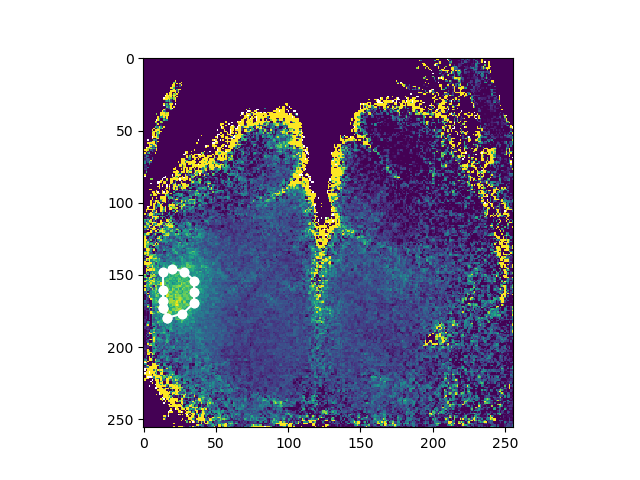

In [83]:
plt.figure()
plt.imshow(mean_stim_frames[126], vmin=0, vmax=0.05)
stim_roi = roipoly(roicolor='w')

<IPython.core.display.Javascript object>


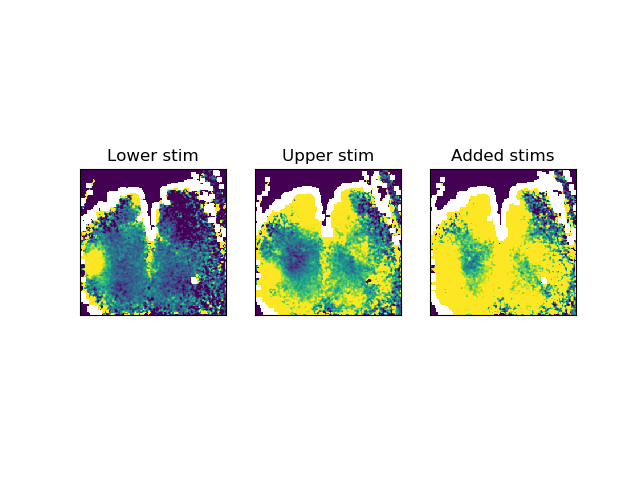

In [84]:
plt.figure()
stim_mask = stim_roi.getMask(mean_stim_frames[125])
plt.imshow(stim_mask)

<IPython.core.display.Javascript object>


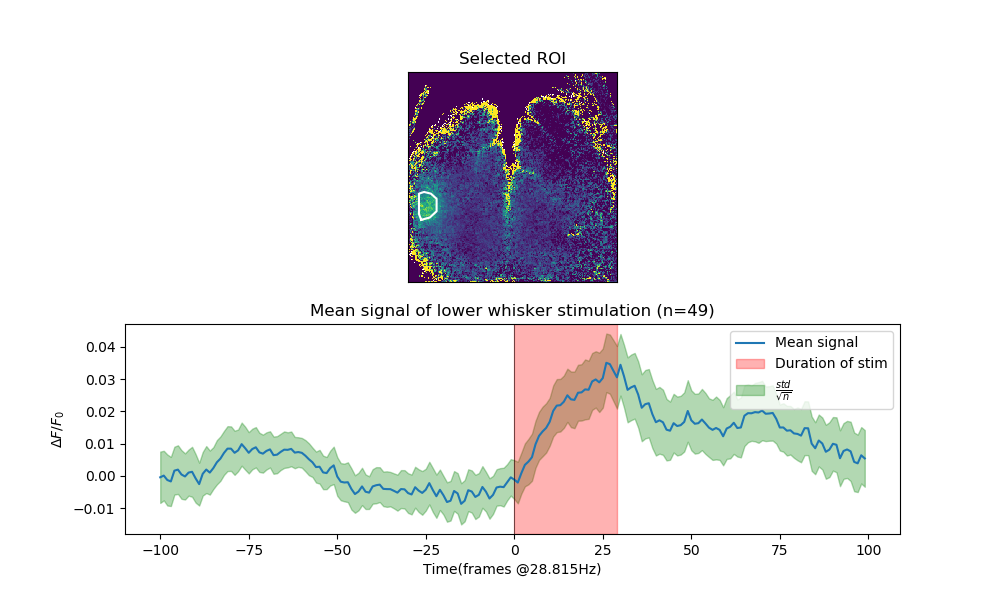

(49, 200, 256, 256)


In [86]:
plt.figure(figsize=(10, 6))
mean_stim_signal = np.mean(mean_stim_frames[:, stim_mask], axis=1)
all_stim_signals = np.mean(all_stim_frames[:, :, stim_mask], axis=2)
std_stim_signal = np.std(all_stim_signals, axis=0)/np.sqrt(all_stim_frames.shape[0])
print(np.shape(all_stim_frames))
time_stim = np.arange(-100, 100, 1)
plt.subplot(232)
plt.title("Selected ROI")
plt.imshow(mean_stim_frames[125], vmin=0, vmax=0.05)
plt.yticks([])
plt.xticks([])
stim_roi.displayROI()
plt.subplot(212)
plt.title("Mean signal of lower whisker stimulation (n=%s)"%str(all_stim_signals.shape[0]))
plt.plot(time_stim, mean_stim_signal, label="Mean signal")
plt.fill_between(time_stim, mean_stim_signal-std_stim_signal, mean_stim_signal+std_stim_signal, alpha=0.3, color='g', label=r"$\frac{std}{\sqrt{n}}$")
plt.ylabel(r"$\Delta F/F_0$")
plt.xlabel("Time(frames @28.815Hz)")
plt.axvline(0, color='k', linewidth=0.4)
plt.axvspan(0, 29, alpha=0.3, color='r', label="Duration of stim")
plt.legend()


<IPython.core.display.Javascript object>


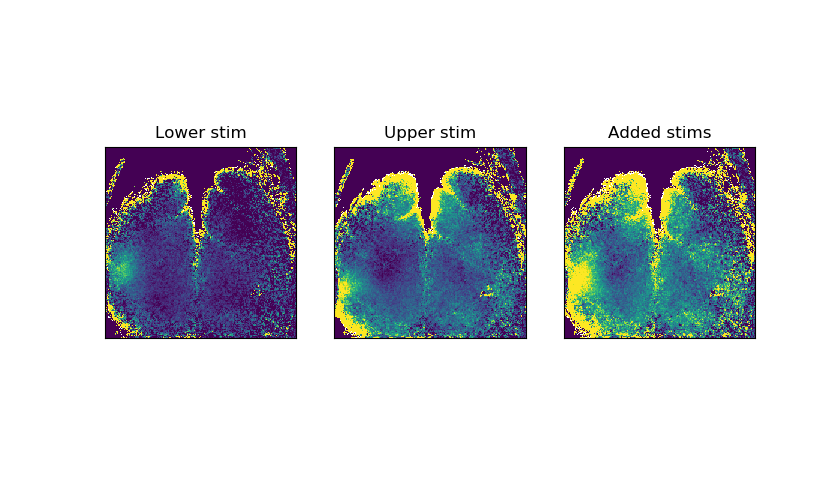

([], <a list of 0 Text xticklabel objects>)

In [93]:
#lower_whisker_peak = np.copy(mean_stim_frames[124])
#upper_whisker_peak = np.copy(mean_stim_frames[124])
lower_whisker_peak[np.where(np.isnan(lower_whisker_peak))] = -10
upper_whisker_peak[np.where(np.isnan(upper_whisker_peak))]= -10
plt.figure()
plt.subplot(131)
plt.title("Lower stim")
plt.imshow((lower_whisker_peak), vmin=0, vmax=0.05)
plt.yticks([])
plt.xticks([])
plt.subplot(132)
plt.title("Upper stim")
plt.imshow((upper_whisker_peak), vmin=0, vmax=0.05)
plt.yticks([])
plt.xticks([])
plt.subplot(133)
plt.title("Added stims")
plt.imshow((lower_whisker_peak+upper_whisker_peak), vmin=0, vmax=0.05, cmap='viridis')
plt.yticks([])
plt.xticks([])